In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Sk1acyabG8ztZRaSNSfR")
project = rf.workspace("objectdetection-hgb5p").project("unet_model")
dataset = project.version(2).download("png-mask-semantic")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to unet_model-2 in png-mask-semantic:: 100%|██████████| 3226/3226 [00:00<00:00, 3682.35it/s]


In [1]:
list=[0,1,2,3]
print(list)

[0, 1, 2, 3]


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="Sk1acyabG8ztZRaSNSfR")
project = rf.workspace().project("unet_model")
model = project.version(2).model


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# infer on a local image
print(model.predict("/content/5559289292_4919d35313_o-56a3bee25f9b58b7d0d394b6.jpg").json())


# save an image annotated with your predictions
model.predict("/content/5559289292_4919d35313_o-56a3bee25f9b58b7d0d394b6.jpg").save("prediction.jpg")

{'predictions': [{'segmentation_mask': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAAAAADRE4smAAALH0lEQVR4nO3d24KjIBBF0QrJ/P8PG3sevCsaVJAq2OthevoatY6AqFEEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKDFK/cCqOZEpO0/dv8rDgE44Fafl5iA9TriQIkbq8R1SseJOFfWJqML8HEi7eHOUU5nUFaczzjYk39vlHI2WzlrcpLbXfcuGT82TDHb7ZN7ATJxvk8XzX4xJT5W6RhgfmC/2OHDO/dChgH1BOAj0gz/n5V7094HF7aMBFQTgLGvazyN+6UAlJGAKgKwHeisa1dvE1B8AA5GufMCut3vTF/ctBwlJKCsAHya5ac/fnw/AZ7atkE/ZU45ARiq3Zw5tJ0q+LMJaMN+zJpCAnB9OmOooVt/YedHr40X9bI5EeQWH6LyDA/HjLSHP2mTpRZgXe8o9V+3AKuyusVXh4tDyqi9iFia8NycvImz6GF/pX/x/RMIZploAbwT97Esm4DNvr1zVVAxbYDKAHxEhnlb17e4CXe8RQK2hd2+cuv9OaM0BmAamG7nXpL4UU1fBAhAOhkOTKYrf+V4mnj6jVISQAC2FrXdb4Oa3e9Yoi8A2et/NEO8UkAG1B3V5K//CR9TS+ulLQAatqjz/tdPw/Leoq0LMLhBbfcD2loAg2z3A8paAKvb0m4rQAsQhdXgEoDqEYA4zA4EGANEZHEkQAsQkcX4EoDKEYDKEYDKEYDKEYDKEYCYDB4GMA8Qn6npAF0tQBH1t7UW

In [4]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers import Conv2D, Input, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info
from keras.layers import add

NETWORK_W = 416
NETWORK_H = 416

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'


from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    skip_connection = None

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1:
            x = ZeroPadding2D(((1, 0), (1, 0)), name='zerop_' + str(conv['layer_idx']))(x)

        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)

        if conv['bnorm']:
            x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)

        if conv['activ'] == 1:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2:
            x = Activation('relu', name='relu_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x], name='add_' + str(conv['layer_idx'] + 1)) if skip else x

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.applications import EfficientNetB1

def multi_unet_model3(n_classes=7, IMG_H=416, IMG_W=416, IMG_CHANNELS=3):

    input_image = Input(shape=(416,416, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x

    # Layer  2
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x

    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x

    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')

    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x

    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x

    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)

    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)

    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}])
    layer_21 = x

    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')

    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x

    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x



    # route  52+25 (layers = -1,-28)
    x = layer_25

    print(x.shape)
    # Upsample to (152, 150, 128)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Upsample to (304, 300, 64)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Further upsample to (512, 512, 32)
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Convolutional layer to adjust the number of channels to 3
    output_tensor = Conv2D(3, (1, 1), activation='relu')(x)
    print(output_tensor.shape)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(output_tensor)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)



    model = Model(inputs=[input_image], outputs=[outputs])

    # Compile the model
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [4]:
!mkdir mask

In [6]:
import os
import shutil

# Replace these paths with your actual source and destination folder paths
source_folder = '/content/unet_model-2/train/'
destination_folder = '/content/mask'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate through the files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('_mask.png'):  # Assuming mask images end with '_mask.png'
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(source_path, destination_path)
        print(f"Moved {filename} to {destination_folder}")


In [7]:



from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


#Resizing images, if needed
SIZE_X = 416
SIZE_Y = 416
n_classes=7#Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/unet_model-2/train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)


#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)



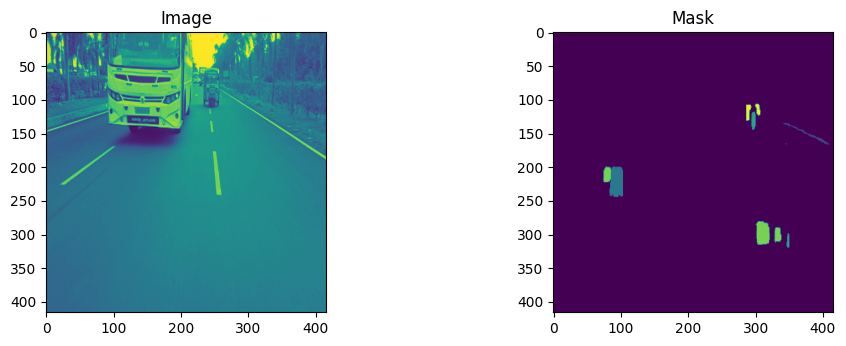

In [8]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()




In [8]:
train_masks.shape
train_images.shape

(1500, 416, 416)

# this is not windows

In [9]:
import glob
import cv2
image_names = glob.glob("/content/unet_model-2/train/*.jpg")
image_names.sort()
image_names = image_names[0:400]


In [8]:
print(image_names)

['/content/unet_model-2/train/00-226-_jpg.rf.01249a81fbf1d75f4e0e30096e91463a.jpg', '/content/unet_model-2/train/00-226-_jpg.rf.2debc5a8fb6e418c792c48fcf07b6774.jpg', '/content/unet_model-2/train/00-226-_jpg.rf.67a2ce61f4798409873e82cf89bf4c9a.jpg', '/content/unet_model-2/train/00-226-_jpg.rf.7e05010948214935f0c4a24b4ae37a6a.jpg', '/content/unet_model-2/train/00-226-_jpg.rf.9452c15ada541dbc1d62c10c990b18d8.jpg', '/content/unet_model-2/train/00-226-_jpg.rf.cb3f9ab7946bf0705a1c1548a0b2f234.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.17c50c6392a110f9908f2699d2ef1ec4.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.3ca12f7b1d7f42f8eab0bde6eef5dc2a.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.4b7f62f928dfeeecf8c0e2e6ff2cedae.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.50f26faa0d11a05f5f2a18578083499e.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.af0d0e0de824d9d48ce2db262a4a4bfa.jpg', '/content/unet_model-2/train/00-227-_jpg.rf.c8cbb445246dbd499930c690c00e8937.jpg', '/c

In [ ]:

#images = [cv2.imread(image, 1) for image in image_names]
#image_dataset = np.array(images)

In [10]:
# Initialize an empty list to store resized images
resized_images = []

# Define the target size (416x416 pixels)
target_size = (416, 416)

# Loop through the list of image file paths
for image_path in image_names:
    # Read the image using OpenCV
    image = cv2.imread(image_path, 1)  # 1 for loading color image

    # Check if the image was successfully loaded
    if image is not None:
        # Resize the image to the target size
        resized_image = cv2.resize(image, target_size)

        # Append the resized image to the list
        resized_images.append(resized_image)

# Convert the list of resized images to a NumPy array
image_dataset = np.array(resized_images)


In [11]:

mask_names = glob.glob("/content/mask/*.png")
mask_names.sort()
mask_names = mask_names[0:400]

In [11]:
print(mask_names)

['/content/mask/00-226-_jpg.rf.01249a81fbf1d75f4e0e30096e91463a_mask.png', '/content/mask/00-226-_jpg.rf.2debc5a8fb6e418c792c48fcf07b6774_mask.png', '/content/mask/00-226-_jpg.rf.67a2ce61f4798409873e82cf89bf4c9a_mask.png', '/content/mask/00-226-_jpg.rf.7e05010948214935f0c4a24b4ae37a6a_mask.png', '/content/mask/00-226-_jpg.rf.9452c15ada541dbc1d62c10c990b18d8_mask.png', '/content/mask/00-226-_jpg.rf.cb3f9ab7946bf0705a1c1548a0b2f234_mask.png', '/content/mask/00-227-_jpg.rf.17c50c6392a110f9908f2699d2ef1ec4_mask.png', '/content/mask/00-227-_jpg.rf.3ca12f7b1d7f42f8eab0bde6eef5dc2a_mask.png', '/content/mask/00-227-_jpg.rf.4b7f62f928dfeeecf8c0e2e6ff2cedae_mask.png', '/content/mask/00-227-_jpg.rf.50f26faa0d11a05f5f2a18578083499e_mask.png', '/content/mask/00-227-_jpg.rf.af0d0e0de824d9d48ce2db262a4a4bfa_mask.png', '/content/mask/00-227-_jpg.rf.c8cbb445246dbd499930c690c00e8937_mask.png', '/content/mask/00-228-_jpg.rf.0faf5d51df92dfdddf3c063907639487_mask.png', '/content/mask/00-228-_jpg.rf.12acf29

In [ ]:

#masks = [cv2.imread(mask,0) for mask in mask_names]
#mask_dataset = np.array(masks)

In [12]:
# Initialize an empty list to store resized mask images
resized_masks = []

# Define the target size (e.g., 416x416 pixels)
target_size = (416, 416)

# Loop through the list of mask image file paths
for mask_path in mask_names:
    # Read the mask image using OpenCV
    mask_image = cv2.imread(mask_path, 0)  # 0 for loading grayscale image

    # Check if the mask image was successfully loaded
    if mask_image is not None:
        # Resize the mask image to the target size
        resized_mask = cv2.resize(mask_image, target_size)

        # Append the resized mask image to the list
        resized_masks.append(resized_mask)

# Convert the list of resized mask images to a NumPy array
mask_dataset = np.array(resized_masks)

In [13]:
image_dataset.shape
mask_dataset.shape

(400, 416, 416)

In [14]:
import numpy as np
np.unique(mask_dataset)


array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

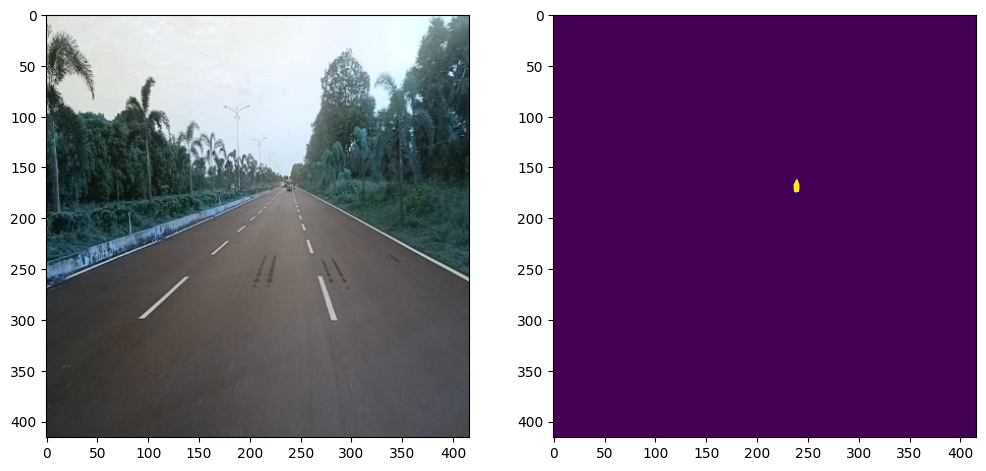

In [14]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

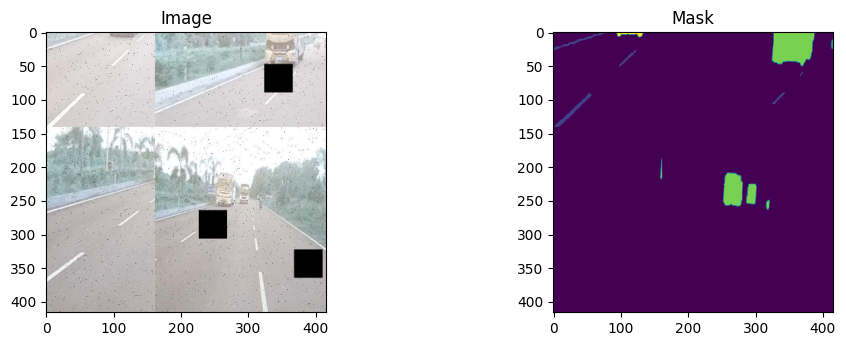

In [15]:

import random
img_number = random.randint(0, len(image_dataset)-1)
img = image_dataset[img_number]
mask = mask_dataset[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()


In [16]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
train_masks_reshaped = mask_dataset.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [17]:
#############################################

#################################################
train_images = np.expand_dims(image_dataset, axis=3)
train_images = normalize(image_dataset, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.10, random_state = 0)


print("Class values in the dataset are ... ", np.unique(y_train.ravel()))


print(n)
print(h)
print(w)

Class values in the dataset are ...  [0 1 2 3 4 5 6]
400
416
416


In [18]:
from keras.utils import to_categorical

# Convert class labels to categorical representation
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [22]:
import tensorflow as tf

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)




def get_model():
    return multi_unet_model3(n_classes=n_classes, IMG_H=IMG_HEIGHT, IMG_W=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights.
#model.load_weights('???.hdf5')
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs')]



history = model.fit(X_train, y_train_cat,
                    batch_size =2,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    callbacks=callbacks,
                    shuffle=False)


416
416
3
(None, 52, 52, 128)
(None, 104, 104, 128)
(None, 208, 208, 64)
(None, 416, 416, 32)
(None, 416, 416, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 convn_0 (Conv2D)            (None, 416, 416, 32)         896       ['input_0[0][0]']             
                                                                                                  
 BN_0 (BatchNormalization)   (None, 416, 416, 32)         128       ['convn_0[0][0]']             
                                                                                                  
 relu_0 (Activation)         (None, 416, 416, 32)         0         ['BN_0[0][0

In [21]:
model.save('modified_unet_csp.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Replace 'acc' with 'accuracy' for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




2/2 [==============================] - 26s 3s/step - loss: 0.1313 - accuracy: 0.9715
Accuracy is =  97.15273976325989 %


NameError: ignored

2/2 [==============================] - 1s 70ms/step - loss: 0.0896 - accuracy: 0.9830
Accuracy is =  98.29975366592407 %


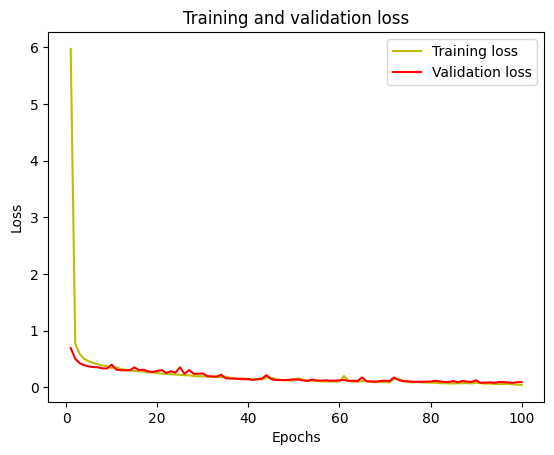

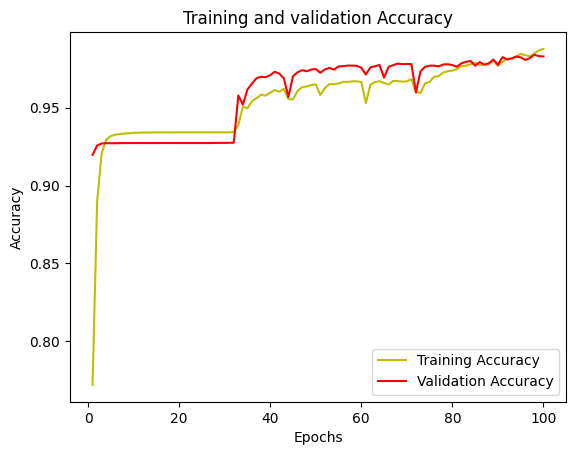

In [ ]:
from keras.models import load_model
import tensorflow as tf
# Save the model in the SavedModel format
tf.saved_model.save(model, 'modified_unet_saved_model')

# Load the saved model
loaded_model = tf.saved_model.load('modified_unet_saved_model')


#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Replace 'acc' with 'accuracy' for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


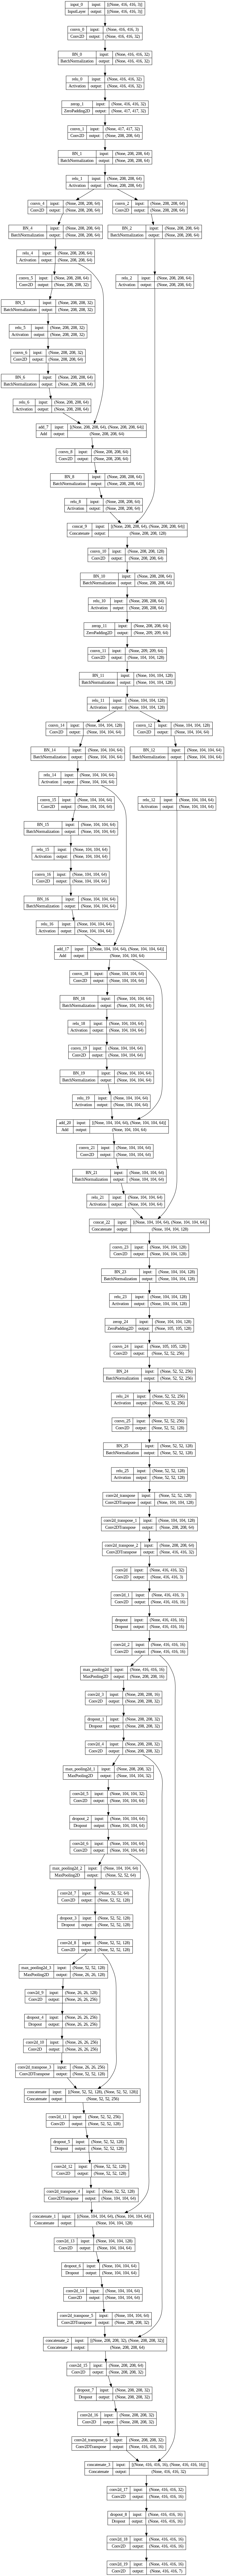

In [1]:
!pip install pydot
!sudo apt-get install graphviz
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the model
model = load_model('/content/modified_unet_csp.hdf5')  # Load your model here

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
##################################

def get_model():
    return multi_unet_model3(n_classes=n_classes, IMG_H=416, IMG_W=416, IMG_CHANNELS=3)
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/modified_unet_csp.hdf5')
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs')]




history = model.fit(X_train, y_train_cat,
                    batch_size = 4,
                    verbose=1,
                    epochs=5,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    callbacks=callbacks,
                    shuffle=False)


#######################################################################



(None, 52, 52, 128)
(None, 104, 104, 128)
(None, 208, 208, 64)
(None, 416, 416, 32)
(None, 416, 416, 3)


In [19]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:, :, :, 0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


2/2 [==============================] - 22s 3s/step
Mean IoU = 0.39804092


In [20]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class_IoUs = []

for i in range(n_classes):
    IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(IoU)
    print(f"IoU for class {i + 1} is: {IoU}")



IoU for class 1 is: 0.9728118777275085
IoU for class 2 is: 0.0699063390493393
IoU for class 3 is: 0.22334431111812592
IoU for class 4 is: 0.3196687698364258
IoU for class 5 is: 0.7472909092903137
IoU for class 6 is: 0.453264057636261
IoU for class 7 is: 0.0


1/1 [==============================] - 1s 1s/step


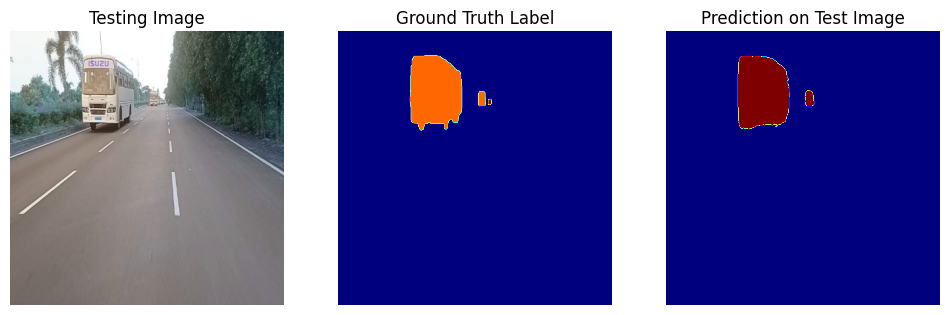

In [21]:
import random
import matplotlib.pyplot as plt

# Randomly select a test image
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# Expand the dimensions to (1, x, y, 3) to represent a single color image
test_img = np.expand_dims(test_img, axis=0)

# Predict using the model
y_pred = model.predict(test_img)
y_pred_argmax = np.argmax(y_pred, axis=3)[0]

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0], cmap='gray')  # Display the color image
plt.axis('off')

plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(y_pred_argmax, cmap='jet')
plt.axis('off')

plt.show()


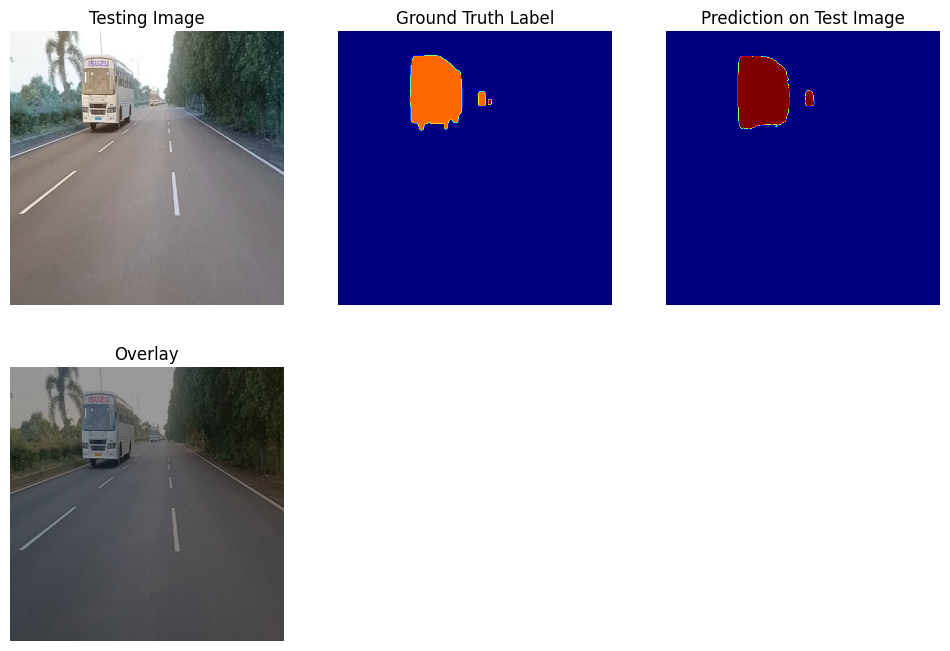

In [22]:


# Create an RGB version of the predicted mask (assuming class labels)
y_pred_rgb = np.zeros((y_pred_argmax.shape[0], y_pred_argmax.shape[1], 3), dtype=np.uint8)
y_pred_rgb[y_pred_argmax == 0] = [0, 0, 0]         # Class 0 (background)
y_pred_rgb[y_pred_argmax == 1] = [0, 255, 0]       # Class 1 (red)

# Blend the original image with the segmented mask
alpha = 0.6  # Adjust the alpha value for blending
overlay = cv2.addWeighted(test_img[0], alpha, y_pred_rgb, 1 - alpha, 0)

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0], cmap='gray')  # Display the color image
plt.axis('off')

plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(y_pred_argmax, cmap='jet')
plt.axis('off')

plt.subplot(234)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 57ms/step


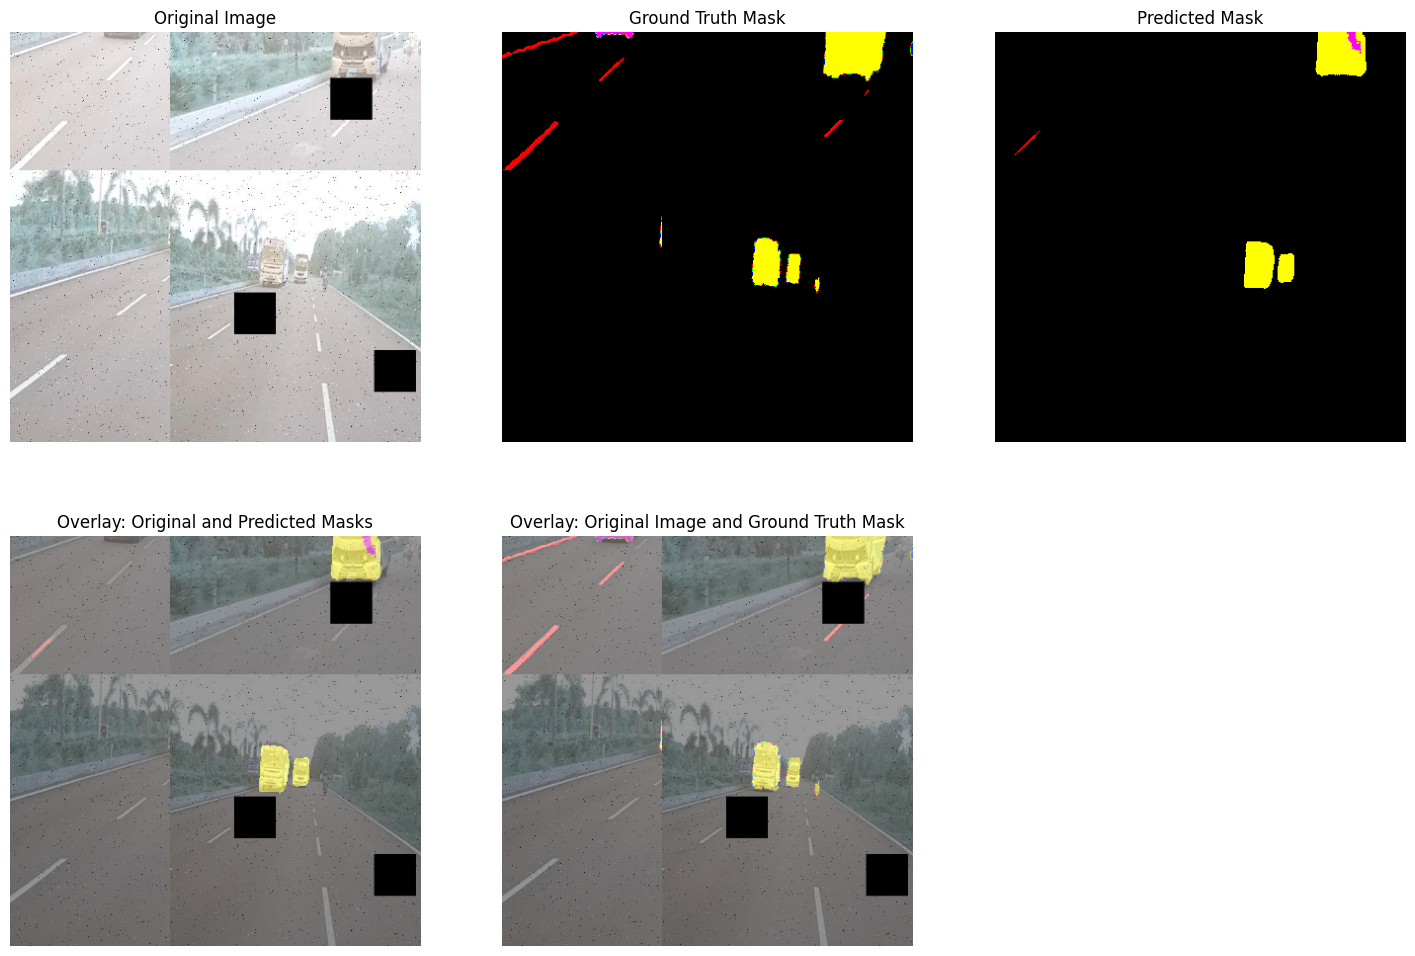

In [24]:
# Assuming you have 7 classes
num_classes = 7

# Map class labels to colors
class_colors = {
    0: [0, 0, 0],    # Background (Black)
    1: [255, 0, 0],  # Class 1 (Red)
    2: [0, 255, 0],  # Class 2 (Green)
    3: [0, 0, 255],  # Class 3 (Blue)
    4: [255, 255, 0],  # Class 4 (Yellow)
    5: [255, 0, 255],  # Class 5 (Magenta)
    6: [0, 255, 255],  # Class 6 (Cyan)
}

# Function to convert class labels to color image
def label_to_color_image(label):
    color_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for class_label, color in class_colors.items():
        mask = (label == class_label)
        color_image[mask] = color
    return color_image



import cv2

# Assuming 'original_image' is the original image (3 channels)
original_image = X_test[15]
ground_truth_mask = y_test[15][:, :, 0]

# Expand the dimensions to (1, x, y, 3) to represent a single color image
test_img = np.expand_dims(original_image, axis=0)

# Predict using the model
y_pred = model.predict(test_img)
y_pred_argmax = np.argmax(y_pred, axis=3)[0]


# Convert predicted mask to color image
predicted_mask_color = label_to_color_image(y_pred_argmax)

# Blend the original image and the predicted mask
overlay_predicted = cv2.addWeighted(original_image, 0.6, predicted_mask_color, 0.4, 0)

# Convert ground truth mask to color image
ground_truth_mask_color = label_to_color_image(ground_truth_mask)

# Blend the original image and the ground truth mask
overlay_ground_truth = cv2.addWeighted(original_image, 0.6, ground_truth_mask_color, 0.4, 0)

# Display the images
plt.figure(figsize=(18, 12))

plt.subplot(231)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth_mask_color)
plt.axis('off')

plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predicted_mask_color)
plt.axis('off')

plt.subplot(234)
plt.title('Overlay: Original and Predicted Masks')
plt.imshow(overlay_predicted)
plt.axis('off')

plt.subplot(235)
plt.title('Overlay: Original Image and Ground Truth Mask')
plt.imshow(overlay_ground_truth)
plt.axis('off')

plt.show()


#approach for better training

In [ ]:
#Apply a trained model on large image
!pip install patchify
from patchify import patchify, unpatchify

large_image = cv2.imread('/content/licence_plate_segmentation_india-1/train/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.38ff3d55fe0ff458f77f962af5c7fd43.jpg', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)

        single_patch = patches[i,j,:,:]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        # Define the new dimensions (e.g., 416x416)
        new_height = 416
        new_width = 416

        # Resize the image
        single_patch_input = cv2.resize(single_patch_input[0], (new_width, new_height))

        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

0 0


ValueError: ignored

In [ ]:
model.save('test_final_200.hdf5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


(1, 416, 416, 3)
1/1 [==============================] - 0s 389ms/step


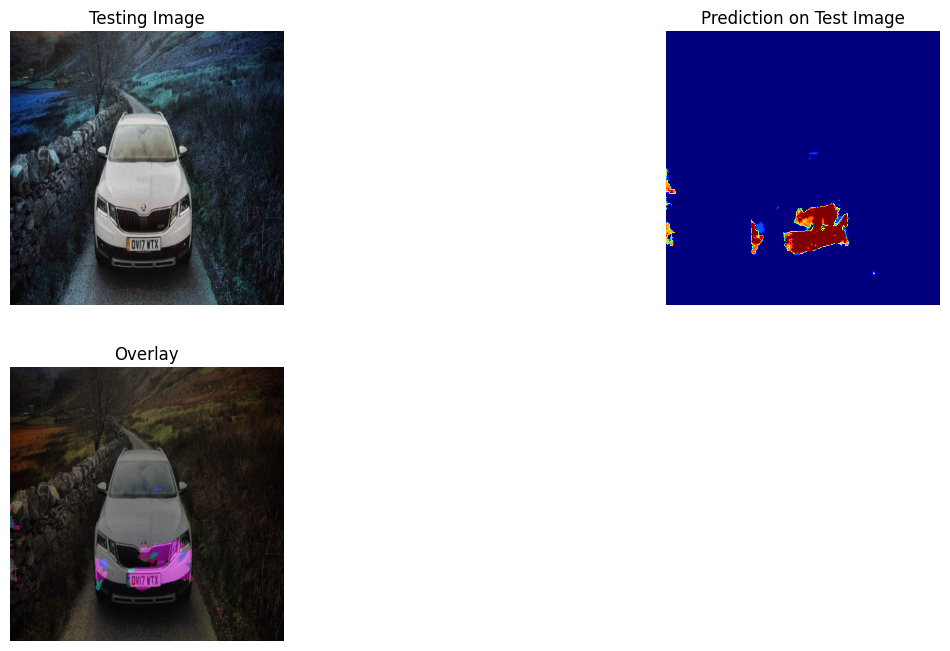

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/modified_unet.hdf5')




# Read the image using OpenCV
resized_images1 = []  # Initialize an empty list to store resized images
image_path1 = "/content/1537136116392.jpg"
image = cv2.imread(image_path1, 1)  # 1 for loading color image

# Check if the image was successfully loaded
if image is not None:
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)

    # Append the resized image to the list
    resized_images1.append(resized_image)

# Convert the list of resized images to a NumPy array
test_img = np.array(resized_images1)

# Expand the dimensions to (1, x, y, 3) to represent a single color image
#test_img = np.expand_dims(test_img, axis=0)
print(test_img.shape)
# Predict using the model
y_pred = model.predict(test_img)
y_pred_argmax = np.argmax(y_pred, axis=3)[0]

import cv2

# Assuming 'original_image' is the original image (3 channels)
original_image = test_img[0]

# Convert predicted mask to color image
predicted_mask_color = np.zeros((y_pred_argmax.shape[0], y_pred_argmax.shape[1], 3), dtype=np.uint8)

# Define color mappings for each class
class_colors = {
    0: [0, 0, 0],    # Background (Black)
    1: [255, 0, 0],  # Class 1 (Red)
    2: [0, 255, 0],  # Class 2 (Green)
    3: [0, 0, 255],  # Class 3 (Blue)
    4: [255, 255, 0],  # Class 4 (Yellow)
    5: [255, 0, 255],  # Class 5 (Magenta)
    6: [0, 255, 255],  # Class 6 (Cyan)
}

# Map class labels to colors in the predicted mask
for class_label, color in class_colors.items():
    predicted_mask_color[y_pred_argmax == class_label] = color

# Blend the original image and the predicted mask
alpha = 0.6  # Adjust the alpha value for blending
overlay = cv2.addWeighted(original_image, alpha, predicted_mask_color, 1 - alpha, 0)

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(y_pred_argmax, cmap='jet')
plt.axis('off')

plt.subplot(234)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

